In [1]:
# === Part 5: Breast Cancer Classification (stable version) ===
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt
import numpy as np

# Load dataset
bc = load_breast_cancer()
Xb, yb = bc.data, bc.target
feature_names = bc.feature_names

# Split with stratification to preserve class balance
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=0.20, random_state=42, stratify=yb
)

print("X_train shape:", Xb_train.shape, "| X_test shape:", Xb_test.shape)
print("Number of features:", len(feature_names))


X_train shape: (455, 30) | X_test shape: (114, 30)
Number of features: 30


In [2]:
# Define models
svm_lin = Pipeline(steps=[
    ("scaler", StandardScaler()),  # scaling is important for SVM
    ("clf", SVC(kernel="linear", probability=True, random_state=42))
])

rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=3,
    random_state=42, n_jobs=-1
)


In [3]:
def evaluate_classifier(model, name: str, X_train, y_train, X_test, y_test, feature_names=None):
    """Fit classifier, print metrics, plot confusion matrix, ROC, and PR curves."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    print(f"[{name}] Accuracy={acc:.4f} | ROC-AUC={roc:.4f} | Avg Precision={ap:.4f}")

    # Confusion matrix heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.title(f"{name}: Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name}: ROC Curve")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall, precision, label=name)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name}: Precision-Recall Curve")
    plt.legend()
    plt.show()

    # Feature importance / weights
    if name.lower().startswith("svm") and hasattr(model.named_steps["clf"], "coef_"):
        coef = np.abs(model.named_steps["clf"].coef_).ravel()
        idx = np.argsort(-coef)[:10]
        print(f"Top 10 SVM(|coef|) features:")
        for i in idx:
            print(f"  {feature_names[i]:<30} | {coef[i]:.4f}")

    if name.lower().startswith("random forest") and hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
        idx = np.argsort(-imp)[:10]
        print(f"Top 10 RandomForest feature importances:")
        for i in idx:
            print(f"  {feature_names[i]:<30} | {imp[i]:.4f}")

    return {"accuracy": acc, "roc_auc": roc, "avg_precision": ap}


[SVM (Linear)] Accuracy=0.9737 | ROC-AUC=0.9964 | Avg Precision=0.9977


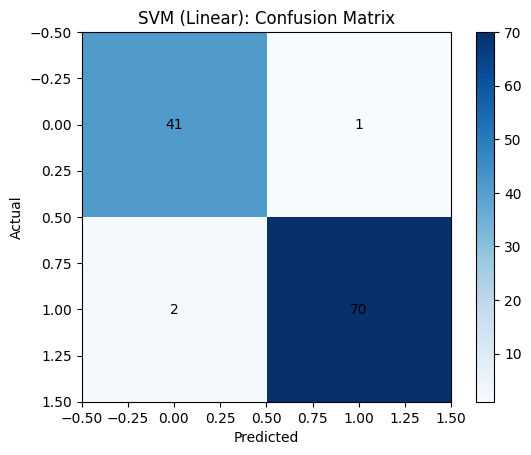

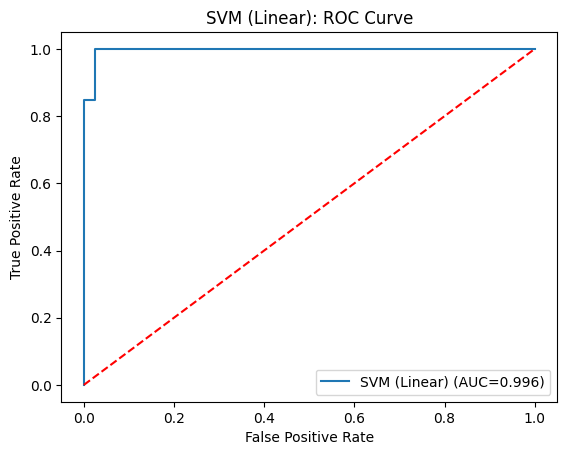

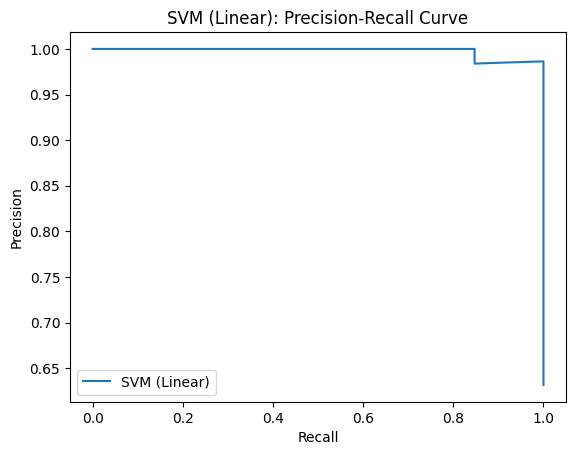

Top 10 SVM(|coef|) features:
  worst texture                  | 1.3852
  worst smoothness               | 0.9293
  area error                     | 0.7946
  mean compactness               | 0.7613
  worst area                     | 0.7342
  radius error                   | 0.7088
  worst concavity                | 0.6883
  worst perimeter                | 0.5872
  perimeter error                | 0.5849
  worst radius                   | 0.5624
[Random Forest] Accuracy=0.9474 | ROC-AUC=0.9937 | Avg Precision=0.9964


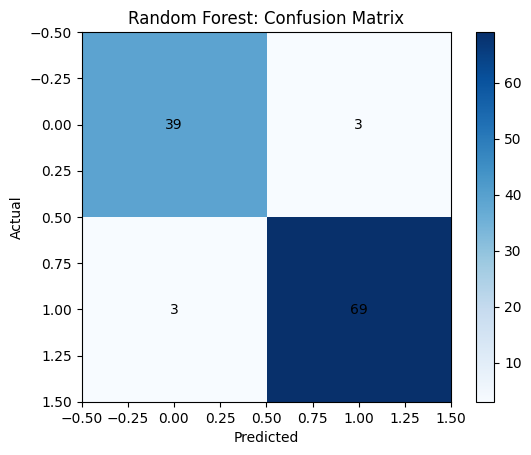

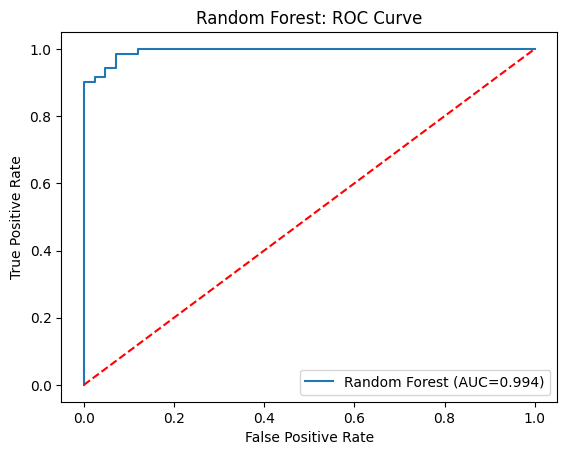

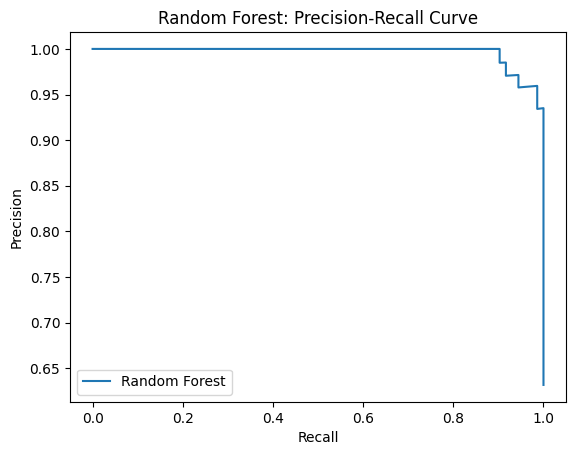

Top 10 RandomForest feature importances:
  worst perimeter                | 0.1378
  worst area                     | 0.1350
  worst concave points           | 0.1177
  mean concave points            | 0.0923
  worst radius                   | 0.0853
  mean radius                    | 0.0639
  mean perimeter                 | 0.0497
  mean concavity                 | 0.0441
  mean area                      | 0.0414
  worst concavity                | 0.0363


In [4]:
svm_scores = evaluate_classifier(svm_lin, "SVM (Linear)", Xb_train, yb_train, Xb_test, yb_test, feature_names)
rf_scores  = evaluate_classifier(rf, "Random Forest", Xb_train, yb_train, Xb_test, yb_test, feature_names)
